In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Input

In [10]:
pir_status = 1 # or 0 which we get from thingspeak
pixel_matrix_list = [[26.75 ,26.75, 25.50,  25.50,  25.50,  25.25, 25.00,   24.25],
 [26.00,   25.50,  25.50,  25.00,24.75 ,24.50,  24.25, 24.50],
 [  27.00,   26.00,   25.25, 24.75, 24.75, 24.50,  24.50,  24.25],
 [27.00,   26.50,  25.25, 25.00,   24.50,  24.50,  24.25, 24.75],
 [ 27.25, 25.00,   25.00,   24.75,24.25 ,24.75, 24.25, 24.25],
 [ 27.50, 24.75, 24.75, 24.75, 24.75, 24.50,  24.25, 23.75],
 [26.75, 25.25, 25.00,   24.50,  24.75, 24.50,  25.00,   24.00],
 [25.25 ,25.00,   24.75, 24.50, 24.00,   24.00,   24.00,   23.50] ] # list of lists derived from thingspeak data

#print(pixel_matrix_list)

cells = np.array(pixel_matrix_list) # this is 8x8 numpy array
#print(cells)

## Heat map

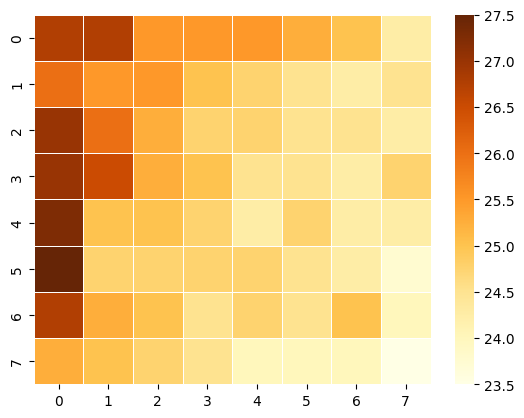

In [11]:
## heat map  plot
heat_map = cells
ax = sns.heatmap(heat_map, linewidth=0.5, cmap = 'YlOrBr')
plt.show()

In [12]:

avg_temp=np.average(cells)
standard_deviation = np.std(cells) # calculate sd of the pixel matrix
count_actv_cells = 0
threshhold_temp = avg_temp + 0.75 # 1 #2 or 1.5 whatever
for a in range(8):
    for r in range(8) :
        if( cells[a][r] >= threshhold_temp): 
            cells[a][r] = 1
            count_actv_cells+=1
        else: cells[a][r] = 0



## Pixelated image

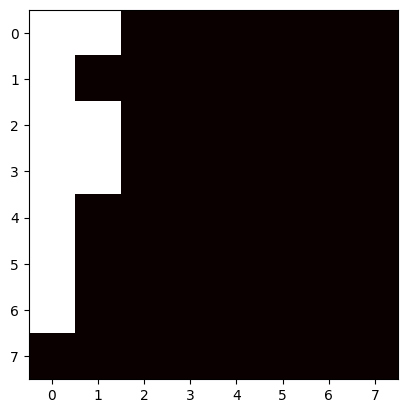

In [13]:
# pixelated image plot
pixelated_image = cells
plt.imshow( pixelated_image , cmap = 'hot' , interpolation = 'nearest' ) 
plt.show()


In [14]:
def doit(arr, count, visited, i, j):
    if(i < 0 or i > 7 or j < 0 or j > 7):return count 
    elif(visited[i][j] != 0):return count 
    elif(arr[i][j] == 0):return count 

    if(arr[i][j] == 1):
        visited[i][j] = 1
        arr[i][j] = 0
        count = count + 1
        count = doit(arr, count, visited, i+1, j)
        count = doit(arr, count, visited, i-1, j)
        count = doit(arr, count, visited, i, j+1)
        count = doit(arr, count, visited, i, j-1)

        return count



def find_blob_sizes(arr):
    visited = np.zeros((8,8))
    count = 0
    ret = []
    for i in range(8):
        for j in range(8):
            if visited[i][j] == 1:
                continue
            count = doit(arr, count, visited, i, j)
            if count > 0 :
                #print(count)
                ret.append(count)
                count = 0
    
    return ret 


## Creating input to model

In [15]:

ans = find_blob_sizes(cells)   #This modifies cells and all values will be zero.
ans.sort(reverse = True)

# attributes to be used as independent variables
if len(ans)>0:
    first = ans[0] # 1st biggest blob size
else: first = 0
if len(ans)>1:
    second = ans[1] # 2nd biggest blob size
else :
    second =0
if len(ans)>2:
    third = ans[2] # 3rd biggest blob size
else: third = 0

mydataset = {
  'pir_state' : [pir_status],
  'first_blob' : [first],
  'second_blob' : [second],
  'third_blob' : [third],
  'mean' : [avg_temp],
  'sd' : [standard_deviation], # standard deviation
  'no_of_active_cells' : [count_actv_cells]
}

input = pd.DataFrame(mydataset)

## prediction using the model

In [16]:
import pickle
from joblib import Parallel, delayed
import joblib

# Load the model from the file
esw_model = joblib.load('j_model.pkl')
  
# Use the loaded model to make predictions
output = esw_model.predict(input)
print("predicted no.of people = ",output[0])


predicted no.of people =  5
